In [ ]:
#Testing MobileNetv2 for classification

In [9]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


In [2]:
# Paths to the datasets
base_path = r"D:\Earth Observatiion\Earth Observe"

In [3]:
# Parameters
img_size = (224, 224)  # Standard input size for MobileNetV2
batch_size = 32

In [4]:
# Load and split the data into training, validation, and testing sets
files = []
labels = []
for label in os.listdir(base_path):
    class_dir = os.path.join(base_path, label)
    if os.path.isdir(class_dir):
        files.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir)])
        labels.extend([label] * len(os.listdir(class_dir)))


In [5]:
# Split data into training+validation and testing sets first
train_valid_files, test_files, train_valid_labels, test_labels = train_test_split(
    files, labels, test_size=0.15, random_state=42
)

# Split training+validation into training and validation sets
train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_valid_files, train_valid_labels, test_size=0.1765, random_state=42  # 0.1765 is approximately 15% of 85%
)

In [6]:
 #ImageDataGenerators for training, validation, and testing
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,             # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,         # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,        # randomly shift images vertically (fraction of total height)
    shear_range=0.2,               # apply shearing transformation
    zoom_range=0.2,                # randomly zoom into images
    horizontal_flip=True,          # randomly flip images horizontally
    fill_mode='nearest'            # strategy for filling in newly created pixels, which can appear after a rotation or a width/height shift
).flow_from_dataframe(
    pd.DataFrame({'filepaths': train_files, 'labels': train_labels}),
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    pd.DataFrame({'filepaths': valid_files, 'labels': valid_labels}),
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    pd.DataFrame({'filepaths': test_files, 'labels': test_labels}),
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 4199 validated image filenames belonging to 12 classes.
Found 901 validated image filenames belonging to 12 classes.
Found 900 validated image filenames belonging to 12 classes.


29/29 [==============================] - 10s 79ms/step - loss: 0.1284 - accuracy: 0.9722
Test Loss: 0.1283894181251526
Test Accuracy: 0.9722222089767456
29/29 [==============================] - 2s 44ms/step


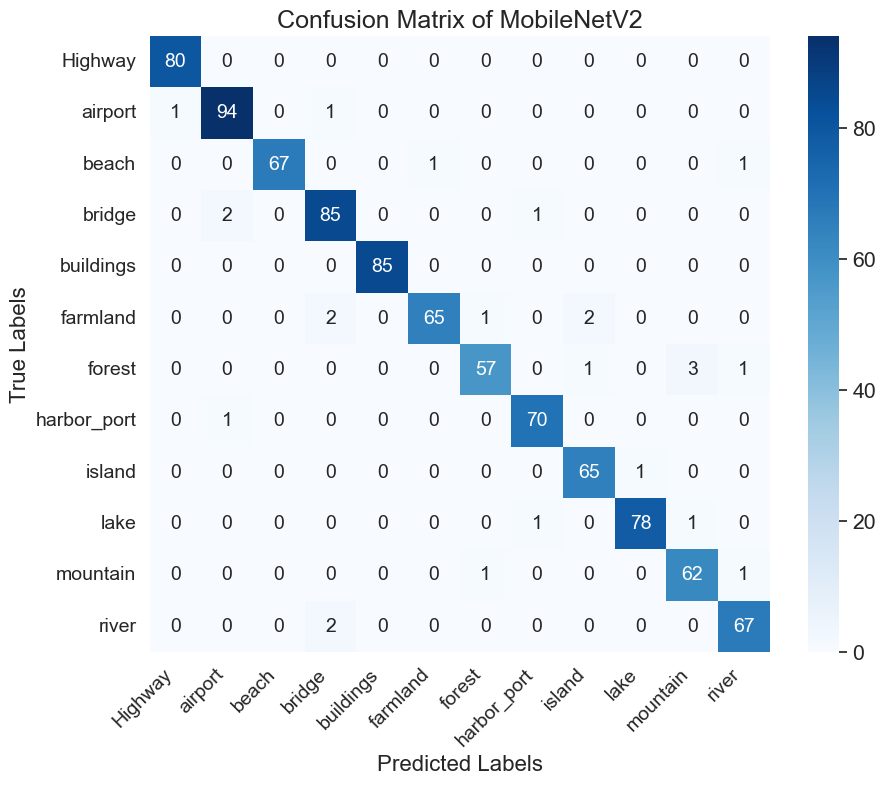


Classification Report:
              precision    recall  f1-score   support

     Highway       0.99      1.00      0.99        80
     airport       0.97      0.98      0.97        96
       beach       1.00      0.97      0.99        69
      bridge       0.94      0.97      0.96        88
   buildings       1.00      1.00      1.00        85
    farmland       0.98      0.93      0.96        70
      forest       0.97      0.92      0.94        62
 harbor_port       0.97      0.99      0.98        71
      island       0.96      0.98      0.97        66
        lake       0.99      0.97      0.98        80
    mountain       0.94      0.97      0.95        64
       river       0.96      0.97      0.96        69

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load the model
model = load_model('MobileNetV2_Earth.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict the test set
test_preds = model.predict(test_gen, steps=len(test_gen))

# Convert predictions from one-hot encoded vectors to class indices
predicted_classes = np.argmax(test_preds, axis=1)

# Retrieve true class labels from the test generator
true_classes = test_gen.classes

# Class labels (ensure these are in the same order as the generator's classes)
class_labels = list(test_gen.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Enhanced Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)  # Adjust font scale for better readability
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, 
                      xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})

heatmap.set_xlabel('Predicted Labels', fontsize=16)
heatmap.set_ylabel('True Labels', fontsize=16)
heatmap.set_title('Confusion Matrix of MobileNetV2', fontsize=18)

plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

plt.show()

# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:")
print(class_report)


In [ ]:
#Testing Converted Tensorflow Lite Model

Test Loss: 0.12811405797475195
Test Accuracy: 0.9711111111111111


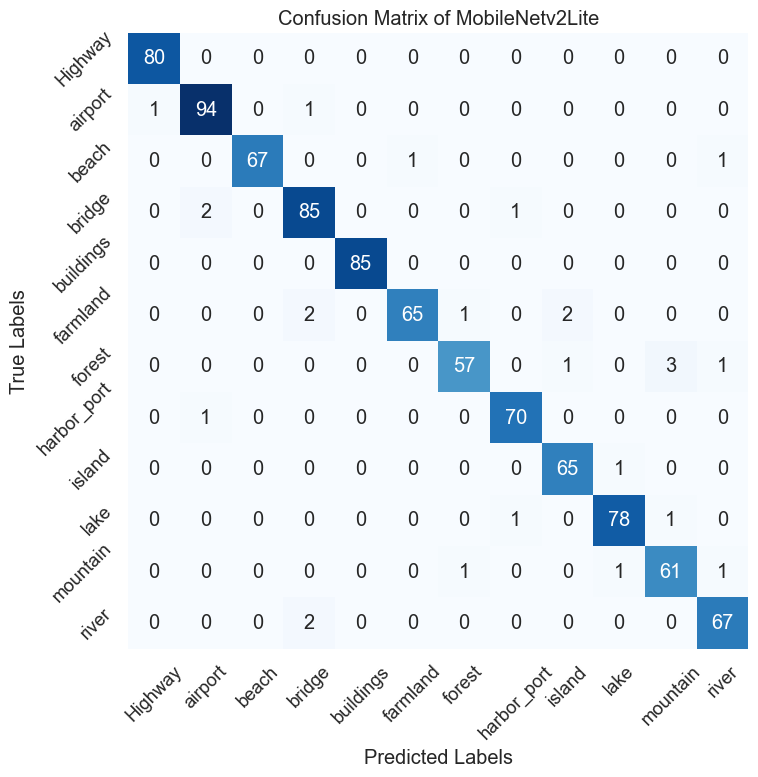


Classification Report:
              precision    recall  f1-score   support

     Highway       0.99      1.00      0.99        80
     airport       0.97      0.98      0.97        96
       beach       1.00      0.97      0.99        69
      bridge       0.94      0.97      0.96        88
   buildings       1.00      1.00      1.00        85
    farmland       0.98      0.93      0.96        70
      forest       0.97      0.92      0.94        62
 harbor_port       0.97      0.99      0.98        71
      island       0.96      0.98      0.97        66
        lake       0.97      0.97      0.97        80
    mountain       0.94      0.95      0.95        64
       river       0.96      0.97      0.96        69

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



In [15]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="MobileNetv2Earth.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Assuming test_gen is your test data generator
true_classes = []
predicted_classes = []
total_loss = 0
num_samples = 0
epsilon = 1e-7  # Small value to avoid log(0)

# Cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.sum(y_true * np.log(y_pred))

for i in range(len(test_gen)):
    # Get the batch of data
    batch_data, batch_labels = test_gen[i]
    
    # Run inference for each example in the batch
    for j in range(len(batch_data)):
        input_data = np.expand_dims(batch_data[j], axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(output_data, axis=1)
        
        true_classes.append(np.argmax(batch_labels[j]))
        predicted_classes.append(predicted_class[0])
        
        # Compute loss for this sample
        true_label = batch_labels[j]
        predicted_prob = output_data[0]
        sample_loss = cross_entropy_loss(true_label, predicted_prob)
        total_loss += sample_loss
        num_samples += 1

# Calculate average loss
test_loss = total_loss / num_samples
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Calculate accuracy
accuracy = np.sum(true_classes == predicted_classes) / len(true_classes)
print("Test Loss:", test_loss)
print("Test Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of MobileNetv2Lite')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys())

print("\nClassification Report:")
print(class_report)


In [ ]:
#Testing Inference time of both models

In [17]:
import tensorflow as tf
import numpy as np
import time

# Load the TFLite model
tflite_interpreter = tf.lite.Interpreter(model_path="MobileNetv2Earth.tflite")
tflite_interpreter.allocate_tensors()

# Load the Keras model
keras_model = tf.keras.models.load_model('MobileNetV2_Earth.keras')

# Get input and output tensors for TFLite model
tflite_input_details = tflite_interpreter.get_input_details()
tflite_output_details = tflite_interpreter.get_output_details()

# Initialize lists to store inference times
tflite_inference_times = []
keras_inference_times = []

# Evaluate inference times for TensorFlow Lite model
for i in range(len(test_gen)):
    batch_data, _ = test_gen[i]
    
    for j in range(len(batch_data)):
        input_data = np.expand_dims(batch_data[j], axis=0).astype(np.float32)
        
        # TensorFlow Lite Inference
        start_time = time.time()
        tflite_interpreter.set_tensor(tflite_input_details[0]['index'], input_data)
        tflite_interpreter.invoke()
        end_time = time.time()
        tflite_inference_time = end_time - start_time
        tflite_inference_times.append(tflite_inference_time)
        
        # Keras Inference
        start_time = time.time()
        _ = keras_model.predict(input_data, verbose=0)
        end_time = time.time()
        keras_inference_time = end_time - start_time
        keras_inference_times.append(keras_inference_time)

# Calculate and print average inference times
avg_tflite_inference_time = np.mean(tflite_inference_times)
avg_keras_inference_time = np.mean(keras_inference_times)

print(f"Average inference time with TFLite model: {avg_tflite_inference_time:.6f} seconds")
print(f"Average inference time with Keras model: {avg_keras_inference_time:.6f} seconds")


Average inference time with TFLite model: 0.013217 seconds
Average inference time with Keras model: 0.072025 seconds
